# Let's build a custom textual inversion

## Downloading some data

Let's use DDG to quickly import some images.

In [1]:
!pip install duckduckgo_search fastai

  Using cached duckduckgo_search-2.2.2-py3-none-any.whl (27 kB)
  Using cached fastai-2.7.9-py3-none-any.whl (225 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached fastcore-1.5.27-py3-none-any.whl (67 kB)
  Using cached fastdownload-0.0.7-py3-none-any.whl (12 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl (12 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
  Attempting uninstall: click
    Found existing installation: click 8.0.3
    Uninstalling click-8.0.3:
      Successfully uninstalled click-8.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.0a0+293.g0930f712e6 requires pandas<1.4.0dev0,>=1.0, but you have pandas 1.4.2 which is incompatib

In [7]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

def search_and_download(term, location, max_images=100):
  !rm -rf ./{location}
  urls = search_images(term, max_images)
  location.mkdir(exist_ok=True, parents=True)
  download_images(location, urls=urls)
  resize_images(location, max_size=400, dest=location)

  failed_downloads = verify_images(get_image_files(location))
  failed_downloads.map(Path.unlink)

In [8]:
search_and_download("IU portrait", Path("downloads/iu"), max_images=10)

## Training

In [2]:
!pip install accelerate diffusers transformers fastcore fastdownload

  Using cached accelerate-0.13.1-py3-none-any.whl (148 kB)
  Using cached diffusers-0.4.2-py3-none-any.whl (229 kB)
  Using cached transformers-4.23.1-py3-none-any.whl (5.3 MB)
  Using cached huggingface_hub-0.10.1-py3-none-any.whl (163 kB)
  Using cached tokenizers-0.13.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [13]:
!python textural-inversion-training.py

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
Steps: 100%|████████████████| 3000/3000 [1:02:17<00:00,  1.25s/it, loss=0.00362]


## Let's Use this

In [4]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from pathlib import Path

In [5]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_grid_flip(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs):
        row = i % rows
        col = (int)((i - row) / rows)
        grid.paste(img, box=(w*col, h*row))
    return grid

def image_resize(grid, factor=3): 
    return grid.resize(((int)(grid.size[0]/factor), (int)(grid.size[1]/factor)))

In [14]:
model_nm = "CompVis/stable-diffusion-v1-4"

output_dir="sd-concept-output"
pipe = StableDiffusionPipeline.from_pretrained(output_dir, torch_dtype=torch.float16).to("cuda")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


  0%|          | 0/51 [00:00<?, ?it/s]

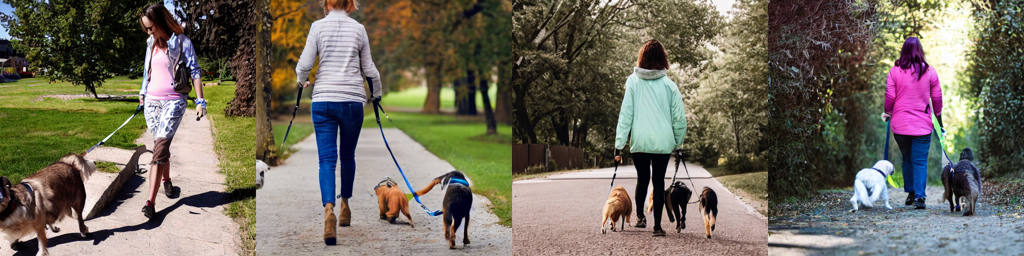

In [46]:
## Let's try to do this as the base
torch.manual_seed(5235)
images = pipe(["a women is walking with a dog"] * 4, num_inference_steps=50, guidance_scale=7.5).images
image_resize(image_grid(images, 1, 4), 2)

  0%|          | 0/51 [00:00<?, ?it/s]

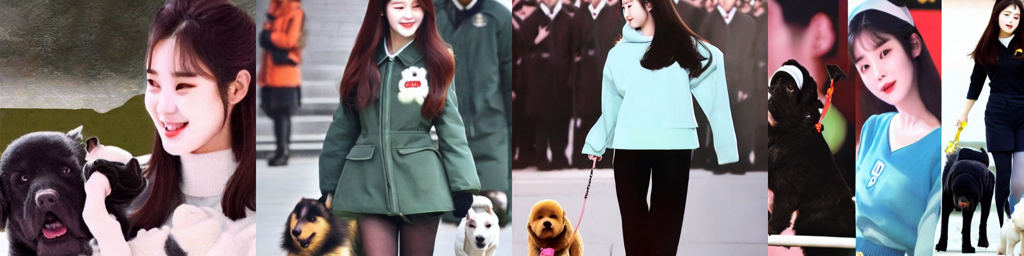

In [48]:
## Let's do this with our trained image
torch.manual_seed(5235)
images = pipe(["<iu> is walking with a dog"] * 4, num_inference_steps=50, guidance_scale=7.5).images
image_resize(image_grid(images, 1, 4), 2)

## Conclusion

Well it's not really what we want. But it's doing a decent job.